# 사전 훈련된 컨브넷 사용하기

ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출

---
## 특성 추출
**사전에 학습**된 네트워크의 표현을 사용해 새로운 샘플에서 흥미로운 특성을 뽑아내는 것
### 합성곱 층 재사용하기
#### 합성곱 층에 의해 학습된 표현은 **일반적**이어서 **재사용** 가능하다!
완전 연결 분류층은 모델이 훈련된 클래스 집합에 특화되어있으므로 합성곱 층만 재사용
      
      
#### 층의 **깊이**에 따라 층에서 추출한 표현의 일반성(그리고 재사용성)의 수준이 다르다!
* 모델의 **하위 층**은 (에지, 색깔, 질감 등과 같이) 지역적이고 매우 **일반적**인 특성 맵을 추출
* **상위 층**은 ('강아지 눈'이나 '고양이 귀'와 같이) 좀 더 **추상적**인 개념을 추출 
* 만약 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르면 전체 합성곱 기반층을 사용하는 것보다는 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋음.
    
    
---
    
## VGG16 합성곱 기반 층 만들기
**weight:** 모델 초기화할 가중치 체크포인트 지정  
**include_top:** 최상위의 완전 연결 분류기 포함 여부  
**input_shape:** 네트워크에 주입할 이미지 텐서 크기

In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                 include_top= False, 
                 input_shape=(150, 150, 3)) 

conv_base.summary()

2022-03-22 22:15:26.772924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-22 22:15:26.773013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (N

## case 1. 새로운 데이터셋에서 합성곱 기반 층 실행 후 출력 -> 독립된 완전 연결 분류기에 입력
사전 훈련된 합성곱 기반 층을 사용한 특성 추출: ImageDataGenerator를 사용해 이미지와 레이블을 넘파이 배열로 추출 (디스크에 저장)
    
* 빠르고 cost 적음
* 데이터 증식 사용 불가

```python
features_batch = conv_base.predict(inputs_batch) 
```
conv_base 모델의 predict 메소드를 호출해 이미지 특성 추출하기


```python
if i * batch_size >= sample_count:
    break
```
제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '../datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


2022-03-22 22:15:27.157989: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-22 22:15:27.209147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


추출된 특성의 크기: (samples, 4, 4, 512)  
완전 연결 분류기에 주입하기 위해 (samples, 8192) 크기로 펼치기

In [3]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### 완전 연결 분류기 정의 후 저장된 데이터와 레이블을 사용해 훈련
```python
model.add(layers.Dropout(0.5))
```
드롭아웃 층 추가하여 과대적합 방지

In [4]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy', # Dog vs Cat -> 이진분류
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30


/Users/youngeun/miniforge3/envs/venv/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
2022-03-22 22:16:12.604793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 10ms/step - loss: 0.5855 - acc: 0.6810 - val_loss: 0.4532 - val_acc: 0.8150
Epoch 2/30
  1/100 [..............................] - ETA: 0s - loss: 0.2739 - acc: 0.9000

2022-03-22 22:16:13.526036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 9ms/step - loss: 0.3981 - acc: 0.8360 - val_loss: 0.3728 - val_acc: 0.8400
Epoch 3/30
100/100 [==============================] - 1s 9ms/step - loss: 0.3270 - acc: 0.8745 - val_loss: 0.3201 - val_acc: 0.8870
Epoch 4/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2884 - acc: 0.8815 - val_loss: 0.2959 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2570 - acc: 0.9020 - val_loss: 0.2809 - val_acc: 0.8890
Epoch 6/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2421 - acc: 0.9075 - val_loss: 0.2699 - val_acc: 0.8920
Epoch 7/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2233 - acc: 0.9165 - val_loss: 0.2628 - val_acc: 0.8940
Epoch 8/30
100/100 [==============================] - 1s 9ms/step - loss: 0.2109 - acc: 0.9200 - val_loss: 0.2638 - val_acc: 0.8910
Epoch 9/30
100/100 [==============================] - 1s 8ms/step - loss: 0.1968 - acc:

그래프 그리기:

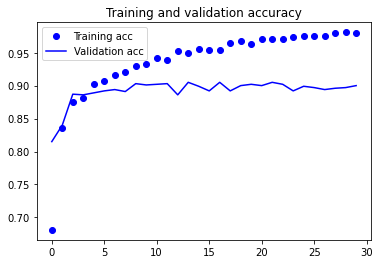

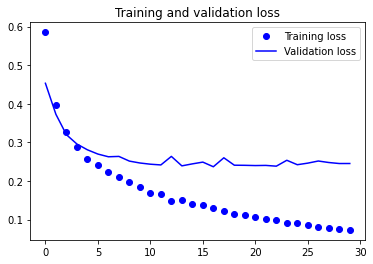

In [5]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

90%의 검증 정확도에 도달하였으나 과대적합 문제 발생! -> **데이터 증식** 사용할 필요가 있다.

---
## case 2. conv_base 모델을 확장하고 입력 데이터를 사용해 end-to-end 로 실행
합성곱 기반 층 위에 완전 연결 분류기 추가
    
* 매우 느림.. GPU 가속 사용할 것
* **데이터 증식 사용 가능함!**

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### 모델 컴파일 & 훈련 전에 합성곱 기반 층 동결
**동결:** 훈련하는 동안 가중치가 업데이트되지 않도록 막기(합성곱 기반층에 의해 사전에 학습된 표현이 훈련하는 동안 수정되지 않도록)

``` python
conv_base.trainable = False
```
두 개의 Dense 층의 가중치만 훈련하도록 동결하기  
trainable 변경 후에 반드시 모델 컴파일!
    

In [7]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base.trainable = False

print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30
conv_base를 동결한 후 훈련되는 가중치의 수: 4


### 동결된 합성곱 기반 층과 함께 모델 엔드-투-엔드로 훈련
train_data **데이터 증식**하여 훈련하기
*단 검증 데이터는 증식하면 안됨!!*
``` python
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
```
**train_dir:** 타깃 디렉토리  
**target_size=(150, 150):** 모든 이미지의 크기를 150 × 150로 변경  
**class_mode='binary':** binary_crossentropy 손실을 사용하므로 이진 레이블 필요  

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


/Users/youngeun/miniforge3/envs/venv/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/var/folders/9_/z_nr8_hd32x51b1zx2flsn080000gn/T/ipykernel_18712/2312850710.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2022-03-22 22:16:39.681574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 22:16:55.943362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 - 24s - loss: 0.5515 - acc: 0.7285 - val_loss: 0.4304 - val_acc: 0.8280 - 24s/epoch - 243ms/step
Epoch 2/30
100/100 - 23s - loss: 0.4151 - acc: 0.8210 - val_loss: 0.3516 - val_acc: 0.8640 - 23s/epoch - 234ms/step
Epoch 3/30
100/100 - 24s - loss: 0.3538 - acc: 0.8475 - val_loss: 0.3064 - val_acc: 0.8780 - 24s/epoch - 237ms/step
Epoch 4/30
100/100 - 24s - loss: 0.3258 - acc: 0.8670 - val_loss: 0.2855 - val_acc: 0.8840 - 24s/epoch - 236ms/step
Epoch 5/30
100/100 - 24s - loss: 0.2988 - acc: 0.8820 - val_loss: 0.2725 - val_acc: 0.8860 - 24s/epoch - 238ms/step
Epoch 6/30
100/100 - 24s - loss: 0.2917 - acc: 0.8895 - val_loss: 0.2635 - val_acc: 0.8930 - 24s/epoch - 237ms/step
Epoch 7/30
100/100 - 24s - loss: 0.2741 - acc: 0.8825 - val_loss: 0.2564 - val_acc: 0.8960 - 24s/epoch - 239ms/step
Epoch 8/30
100/100 - 23s - loss: 0.2685 - acc: 0.8890 - val_loss: 0.2695 - val_acc: 0.8840 - 23s/epoch - 235ms/step
Epoch 9/30
100/100 - 23s - loss: 0.2595 - acc: 0.8940 - val_loss: 0.2493 - val_acc:

모델 저장하기:  


In [9]:
model.save('cats_and_dogs_small_3.h5')

그래프 그리기:

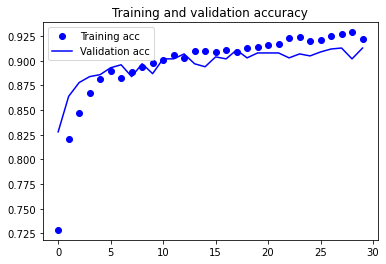

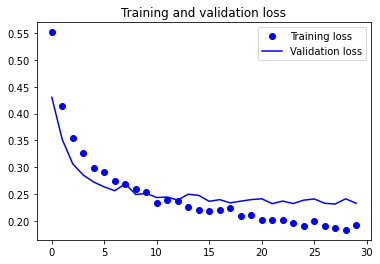

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

이전보다 과대적합 문제 해소됨..!

테스트 데이터로 모델 평가 결과: 0.9050000309944153

---
## 미세 조정
특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련

* 맨 위의 **분류기(완전 연결 분류기)가 훈련된 후** 합성곱 기반의 상위 층 미세조정 가능
    * 미리 훈련되지 않으면 훈련하는 동안 너무 큰 오차 신호가 네트워크에 전파
    * 미세조정될 층들이 사전에 학습한 표현 망가뜨리지 않도록 분류기 미리 훈련시키기

1. 사전 훈련된 기반 네트워크 위에 새로운 네트워크 추가
2. 기반 네트워크 동결
3. 새로 추가한 네트워크 훈련
4. 기반 네트워크에서 **일부 층의 동결 해제**
5. 동결 해제한 층과 새로 추가한 층 함께 훈련

1,2,3단계는 특성 추출 단계에서 이미 완료함!

마지막 세 개의 합성곱 층을 미세 조정하자! 
* block4_pool까지 모든 층은 동결 
* block5_conv1, block5_conv2, block5_conv3 층은 학습 대상으로

### 왜 미세조정은 적은 층만 하는지?
하위 층은 일반적이고 재사용 가능한 특성,, 상위 층은 데이터에 특화된 특성을 인코딩\
새로운 문제에 재활용하려면 **구체적이고 특화된 특성만 미세 조정**하는 것이 유리!!

훈련해야 할 파라미터가 많을수록 과대적합의 위험이 커짐..\
**작은 데이터셋으로 합성곱 기반층 전체를 훈련하기엔 위험**하다...!!!

In [18]:
conv_base.summary()

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### 학습률을 낮춘 RMSProp 옵티마이저 사용해 컴파일
#### 학습률을 낮추는 이유?:
미세 조정하는 세 개의 층에서 학습된 표현을 조금씩 수정하기 위해서 \
변경량이 너무 크면 학습된 표현에 나쁜 영향을 끼칠 수 있음!

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

### 모델 훈련하기

In [29]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50,
                              verbose=2)

Epoch 1/100


/var/folders/9_/z_nr8_hd32x51b1zx2flsn080000gn/T/ipykernel_18712/3420237676.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
2022-03-22 22:49:53.769515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 22:50:10.188827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 - 24s - loss: 0.0823 - acc: 0.9730 - val_loss: 0.2818 - val_acc: 0.8990 - 24s/epoch - 243ms/step
Epoch 2/100
100/100 - 24s - loss: 0.0993 - acc: 0.9670 - val_loss: 0.2786 - val_acc: 0.9050 - 24s/epoch - 238ms/step
Epoch 3/100
100/100 - 24s - loss: 0.0859 - acc: 0.9695 - val_loss: 0.2758 - val_acc: 0.9070 - 24s/epoch - 237ms/step
Epoch 4/100
100/100 - 23s - loss: 0.0862 - acc: 0.9655 - val_loss: 0.2760 - val_acc: 0.9050 - 23s/epoch - 232ms/step
Epoch 5/100
100/100 - 23s - loss: 0.0852 - acc: 0.9705 - val_loss: 0.2764 - val_acc: 0.9050 - 23s/epoch - 235ms/step
Epoch 6/100
100/100 - 23s - loss: 0.0904 - acc: 0.9690 - val_loss: 0.2783 - val_acc: 0.9000 - 23s/epoch - 234ms/step
Epoch 7/100
100/100 - 23s - loss: 0.0921 - acc: 0.9675 - val_loss: 0.2793 - val_acc: 0.9000 - 23s/epoch - 232ms/step
Epoch 8/100
100/100 - 23s - loss: 0.0873 - acc: 0.9730 - val_loss: 0.2801 - val_acc: 0.8990 - 23s/epoch - 234ms/step
Epoch 9/100
100/100 - 24s - loss: 0.0901 - acc: 0.9690 - val_loss: 0.2930 - 

Epoch 71/100
100/100 - 23s - loss: 0.0827 - acc: 0.9695 - val_loss: 0.2944 - val_acc: 0.9020 - 23s/epoch - 234ms/step
Epoch 72/100
100/100 - 24s - loss: 0.0783 - acc: 0.9740 - val_loss: 0.2973 - val_acc: 0.8970 - 24s/epoch - 236ms/step
Epoch 73/100
100/100 - 24s - loss: 0.0713 - acc: 0.9735 - val_loss: 0.2930 - val_acc: 0.9050 - 24s/epoch - 237ms/step
Epoch 74/100
100/100 - 24s - loss: 0.0699 - acc: 0.9760 - val_loss: 0.2957 - val_acc: 0.9060 - 24s/epoch - 236ms/step
Epoch 75/100
100/100 - 24s - loss: 0.0708 - acc: 0.9785 - val_loss: 0.2979 - val_acc: 0.9000 - 24s/epoch - 236ms/step
Epoch 76/100
100/100 - 24s - loss: 0.0767 - acc: 0.9730 - val_loss: 0.2960 - val_acc: 0.9020 - 24s/epoch - 236ms/step
Epoch 77/100
100/100 - 24s - loss: 0.0760 - acc: 0.9725 - val_loss: 0.3032 - val_acc: 0.8940 - 24s/epoch - 236ms/step
Epoch 78/100
100/100 - 24s - loss: 0.0696 - acc: 0.9765 - val_loss: 0.2983 - val_acc: 0.9020 - 24s/epoch - 235ms/step
Epoch 79/100
100/100 - 23s - loss: 0.0728 - acc: 0.9750 

모델 훈련 후 저장

In [30]:
model.save('cats_and_dogs_small_4.h5')

결과 그래프 그리기:

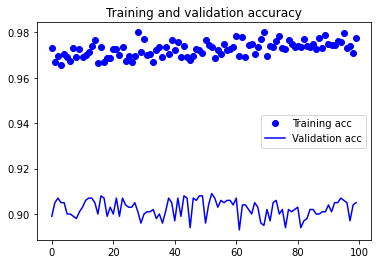

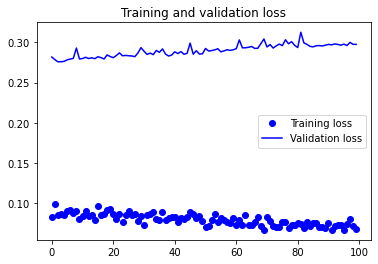

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

지수 이동 평균으로 그래프 부드럽게:

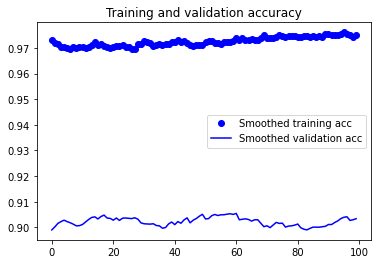

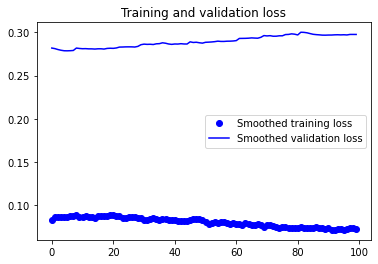

In [32]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### loss 곡선은 악화되었는데 어떻게 정확도가 향상되었지?
그래프는 개별적인 손실 값의 평균  
정확도에 영향 미치는 것은 **손실 값의 분포!!**(정확도는 모델이 예측한 클래스 확률이 어떤 임계값을 넘었는지에 대한 결과)\
=> 모델이 더 향상되더라도 평균 손실에 반영되지 않을 수 있다.

### 테스트 데이터로 모델 평가하기

In [33]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/var/folders/9_/z_nr8_hd32x51b1zx2flsn080000gn/T/ipykernel_18712/2632914869.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.9110000729560852


---
## 정리
1. Convnet은 컴퓨터 비전 작업에 가장 뛰어난 머신 러닝 모델,, 아주 작은 데이터셋도 괜찮은 성능 보인다.
2. **작은 데이터셋은 과대적합**이 큰 문제! -> **데이터 증식**으로 억제하자
3. **특성 추출**로 새로운 데이터셋에 **기존 convnet 재사용** 가능!
4. 특성 추출을 보완하기 위해 **미세조정** 사용(미세조정: 기존 모델에서 전에 학습한 표현의 일부를 새로운 문제에 적응시키는 방법)